This notebook is intended to produce the vizualisations of Figure 4 from the paper. 

It deals with regularized optimal transport for Monge-Kantorovich quantiles in dimension `d=2`.

It compares different methods from a qualitative (smoothing effect of regularization) and quantitative (convergence graphs) point of view.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import ot
sns.set()

### Generate the data 

[2.31164683e-05 3.33553292e-01]


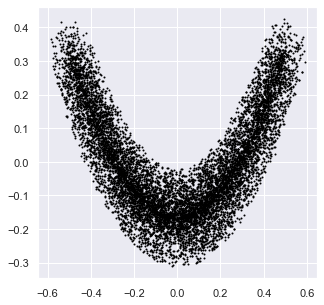

In [2]:
J = 10**4

######################
# Banana shaped data 
######################

d = 2 
X = -1 + 2 * np.random.random_sample((J,))
Phi = 2 * np.pi * np.random.random_sample((J,))
Z = np.random.random_sample((J,))
R = 0.2 * Z * (1+(1-abs(X))/2)
y1 = X + R * np.cos(Phi)
y2 = X**2 + R * np.sin(Phi)
Y = np.array([y1,y2])
Y = Y.T

# Center-reduce is necessary for computational reasons in EOT
scale = 2
print(np.mean(Y,axis=0))
Y = (Y-np.mean(Y,axis=0))/scale

plt.figure(figsize=(5,5))
plt.scatter(Y.T[0],Y.T[1],color="black",s=1)

### Grid from the spherical uniform distribution

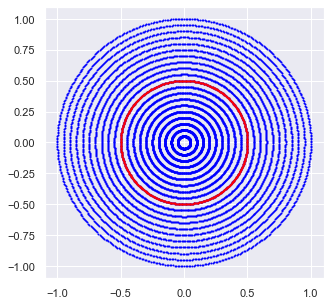

In [4]:
# Choix de la grille en coordonnées polaires
p1 = 20 # Nombre de rayons
p2 = 500 # Nombre d'angles

grid_r = np.mgrid[1:(p1+1), 1:(p2+1)][0]/p1
grid_theta = (np.mgrid[1:(p1+1), 1:(p2+1)][1]/p2)*2*np.pi

# Vizualise points in cartesian coordinates
grid_x1 = grid_r*np.cos(grid_theta)
grid_x2 = grid_r*np.sin(grid_theta)
grid_x = np.array([grid_x1,grid_x2])

plt.figure(figsize=(5,5))
plt.scatter(grid_x1[:].reshape(p1*p2,1),grid_x2[:].reshape(p1*p2,1),color="blue",s=1)

# Vizualise a circle, i.e. the antecedent from the quantile map of a quantile contour.
k = int(p1/2-1)
plt.scatter(grid_x1[k,:].reshape(p2,1),grid_x2[k,:].reshape(p2,1),color="red",s=1)

### Functions for our FFT scheme

In [5]:
def cost_fft2(grid_x,Y):
    diff1 = grid_x[0]-Y[0]
    diff2 = grid_x[1]-Y[1]
    return(0.5*(diff1**2 + diff2**2))


def c_transform_fft2(u, grid_x, y, eps=0.1):
    """Calculate the c_transform of u"""
    arg = (u - cost_fft2(grid_x, y))/eps
    to_sum = np.exp(arg)
    return(-eps*np.log(np.mean(to_sum)))
    
def grad_heps_fft2(u, grid_x, y, eps=0.1):
    """
    Calculate the gradient h_eps 
    """

    F_u = np.exp((u - cost_fft2(grid_x, y))/eps)
    argD = np.mean(F_u)
    grad = -np.fft.fft2(F_u)/argD

    return(grad)

def h_eps_fft2(u, grid_x, y, eps=0.1):
    """
    Calculate the function h_eps whose expectation equals H_eps.
    """
    return(c_transform_fft2(u, grid_x, y, eps)-eps)

def Robbins_Monro_Algo_fft2(grid_x, Y, u, eps=0.1, gamma= 1, c = 3/4, alpha= 0, epoch = 1):   
    n = Y.shape[0]
    n_iter = n*epoch
    
    # Tirage des Y le long des itérations
    if (epoch == 1):
        sample = np.arange(n)
    else:
        sample = np.random.choice(a=np.arange(n), size=n_iter)
    
    # Choix de la matrice de poids W pour l'algorithme basé sur la FFT
    p1 = grid_x[0].shape[0]
    p2 = grid_x[0].shape[1]
    freqs = np.meshgrid(np.fft.fftfreq(p1),np.fft.fftfreq(p2))
    freqs[0][0,0] = 1/p1
    freqs[1][0,0] = 1/p2
    # W = 1/(np.sqrt((p1*freqs[0])**2+(p2*freqs[1])**2)**alpha).T
    W = 1/((p2*freqs[1])**alpha).T
    
    # Stockage des estimateurs recursifs.
    W_hat_storage = np.zeros(n_iter)
    h_eps_storage = np.zeros(n_iter)

    # Initialisation du vecteur u
    fft_u = np.fft.fft2(u)
    
    # Premiere iteration pour lancer la boucle.
    y_0 = Y[sample[0],:] 
    W_hat_storage[0] = h_eps_fft2(u, grid_x, y_0, eps)
    h_eps_storage[0] = h_eps_fft2(u, grid_x, y_0, eps)

    # Boucle de Robbins Monro.
    for k in range(1,n_iter):

        # Tirage d'une réalisation selon la loi mu.
        y = Y[sample[k],:]
        
        # Mise à jour de la valeur de fft_u et mise à zéro de son intégrale
        u = np.real(np.fft.ifft2(fft_u))
        fft_u = fft_u + gamma/((k+1)**c) * W * grad_heps_fft2(u, grid_x, y, eps)
        fft_u[0,0] = 0
        
        # Stockage de la valeur de h_eps 
        h_eps_storage[k] = h_eps_fft2(u, grid_x, y, eps)
        
        # Evaluation de l'approximation de la divergence de Sinkhorn.
        W_hat_storage[k] = k/(k+1) * W_hat_storage[k-1] + 1/(k+1) * h_eps_storage[k]
        
        # Stockage de la valeur de u à chaque itération
        u = u-np.mean(u)
        
    L = [u, W_hat_storage]
    
    return(L)

### Functions for the Robbins-Monro scheme

In [6]:
# Functions for estimating the entropic map, or barycentric projection after RM scheme.
def quantile(eps,x,Y,v):
    J = len(Y)
    exp =  np.exp( (v-cost(x,Y))  /eps )
    pi_ = exp / np.sum(exp)
    y_i_pi_i = np.prod([pi_,Y.T]).T
    return(np.sum(y_i_pi_i,axis=0))

def cost(x,Y):
    """
    Squared euclidean distance between x and the J points of Y.
    if x is the ith point of the support of the distribution, 
    the result is the ith line of the cost matrix.
    
    """
    diff = Y-x
    return(0.5*np.linalg.norm(diff, axis = 1)**2)

def c_transform(v, x, Y, nu, eps=0):
    """Calculate the c_transform of g"""
    if eps > 0:
        arg = (v - cost(x, Y))/eps
        to_sum = np.exp(arg)*nu
        return(-eps*np.log(np.sum(to_sum)))
    else:
        cost_x = cost(x,Y)
        return(np.min(cost_x-v))
    
def grad_heps(v, x, Y, nu, eps=0):
    """
    Calculate the gradient h_eps 
    """
    if eps > 0:
        pi = nu * np.exp((v-cost(x,Y))/eps)
        pi = pi/pi.sum()
        return(nu-pi)
    else:
        cost_x = cost(x,Y)
        j_star = np.argmin(cost_x - v)
        to_return = nu.copy()
        to_return[j_star] = nu[j_star] - 1
        return(to_return)

def h_eps(v, x, Y, nu, eps=0):
    """
    Calculate the function h_eps whose expectation equals H_eps.
    """
    return(np.sum(v*nu)+c_transform(v,x,Y,nu,eps)-eps)


def Robbins_Monro_Algo(Y, eps=1, n_iter=10000):
    """
    Robbins-Monro algorithm
    """    
    c = 3/4
    J = len(Y)
    nu = (1/J)*np.ones(J)
    gamma = eps*J/2
    
    # Stockage des estimateurs recursifs.
    W_hat_storage = np.zeros(n_iter)
    h_eps_storage = np.zeros(n_iter) 
    
    # Initialisation du vecteur dual v
    v = np.zeros(J)
    
    # Premiere iteration pour lancer la boucle.
    Z = np.random.normal(0,1,2)
    Z = Z / np.sqrt(np.sum(Z**2))
    r = np.random.random()
    x_0 = r*Z
    
    W_hat_storage[0] = h_eps(v, x_0, Y, nu, eps)
    h_eps_storage[0] = h_eps(v, x_0, Y, nu, eps)

    
    # Boucle de Robbins Monro.
    for k in range(1,n_iter):
        # Tirage d'une réalisation selon la loi mu.
        Z = np.random.normal(0,1,2)
        Z = Z / np.sqrt(np.sum(Z**2))
        r = np.random.random()
        x = r*Z
    
        # Mise à jour de la valeur de v.
        v = v + gamma/((k+1)**c) * grad_heps(v, x, Y, nu, eps)
        
        # Stockage de la valeur de h_eps au point (x,g).
        h_eps_storage[k] = h_eps(v, x, Y, nu, eps)
    
        # Evaluation de l'approximation de la divergence de Sinkhorn.
        W_hat_storage[k] = k/(k+1) * W_hat_storage[k-1] + 1/(k+1) * h_eps_storage[k]
        L = [v, W_hat_storage]
        
    return(L)

### Learning semi-dual problem via our FFT scheme 

In the next cell, the parameter `epoch` can be changed between 1,10,100, in order to changer the final number of iterations of each algorithm, and to obtain the different lines of the left-hand column of Figure 4.

In [22]:
# Taux d'apprentissage fixé en fonction de epsilon
eps = 0.005
gamma = eps

# Choix du nombre d'epoch
epoch = 100 
n = Y.shape[0] 
n_iter = n*epoch

# Initilisation
u0 = np.zeros([p1,p2])    

# Compute the regularized maps by RM-FTT
res_RM_fft = Robbins_Monro_Algo_fft2(grid_x, Y, u=u0, eps=eps, gamma = gamma, c = 3/4, alpha = 0, epoch = epoch)
hat_u = res_RM_fft[0]
hat_W = res_RM_fft[1]

KeyboardInterrupt: 

(0.064, 0.074)

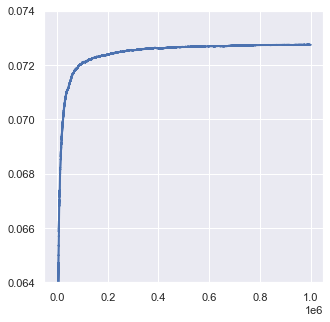

In [27]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(n_iter),hat_W)
n_start = 100
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)
plt.ylim([0.064,0.074])

In [24]:
# Calculus of the gradient of u by finite differences in polar coordinates
diff_hat_u = np.gradient(hat_u)
diff_grad_hat_u = np.array([diff_hat_u[0]*p1,-diff_hat_u[1]*p2/(2*np.pi)])

# Change of variable,
# Rotation of the gradient in polar coordinates towards the cartesian coordinates
A1 = np.array([np.cos(grid_theta),(1/grid_r)*np.sin(grid_theta)])
A2 = np.array([np.sin(grid_theta),(-1/grid_r)*np.cos(grid_theta)])

rot_diff_grad_hat_u1 = diff_grad_hat_u[0]*A1[0]+diff_grad_hat_u[1]*A1[1]
rot_diff_grad_hat_u2 = diff_grad_hat_u[0]*A2[0]+diff_grad_hat_u[1]*A2[1]
rot_diff_grad_hat_u = np.array([rot_diff_grad_hat_u1,rot_diff_grad_hat_u2])

# Optimal transport mapping in cartesian coordinates
hat_T1 = grid_x[0] - rot_diff_grad_hat_u[0]
hat_T2 = grid_x[1] - rot_diff_grad_hat_u[1]
hat_T = np.array([hat_T1,hat_T2])

### Learning semi-dual problem by the regularized SGD

In [8]:
res_RM = Robbins_Monro_Algo(Y,eps=eps, n_iter=n_iter)

(0.06, 0.07)

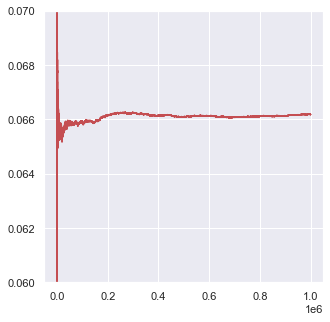

In [28]:
v1 = res_RM[0]
hat_W_RM = res_RM[1]
plt.figure(figsize=(5,5))
plt.plot(np.arange(n_iter),hat_W_RM,'r')
plt.ylim([0.06,0.07])

In [16]:
###############################################################
# Regularized quantile contours using barycentric projection
###############################################################

hatT_RM1 = np.zeros([p1,p2])
hatT_RM2 = np.zeros([p1,p2])

for k in range(p1):
    for l in range(p2):
        x = np.array([grid_x[0][k,l],grid_x[1][k,l]])
        Tx = quantile(eps,x,Y,v1)
        hatT_RM1[k,l] = Tx[0]
        hatT_RM2[k,l] = Tx[1]

hatT_RM = np.array([hatT_RM1,hatT_RM2])

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### Learning semi-dual problem by unregularized SGD

We believe that this procedure shall be detailed, the others being already detailed in the corresponding papers.

Let $\Psi$ be the Kantorovich potential, with the slight abuse of notation function estimated in $J$ points/vector :
$$
\Psi = argmin_{\psi \in \mathbb{R}^J} \mathbb{E}(\max_k \{ \langle x_k,U\rangle - \psi_k \}) + \mathbb{E}(\psi(X)).
$$
This rewrites
$$
\Psi = argmin_{\psi \in \mathbb{R}^J} \mathbb{E}[g(U,\psi)],
$$
if 
$$
g(u,\psi) = \max_k \{ \langle x_k,u\rangle - \psi_k \} + \frac{1}{J}\sum_{k=1}^J \psi_k.
$$

A subgradient of $g$ can be computed by the envelop theorem, or explicitly :
$$
\frac{\partial g(u,\psi) }{\partial \psi_i} = \frac{1}{J}-1 \text{ si } \langle x_i,u\rangle - \psi_i = \max_k \{ \langle x_k,u\rangle - \psi_k \},
$$
and
$$
\frac{\partial g(u,\psi) }{\partial \psi_i}= \frac{1}{J} \text{ elsewhere.}
$$

Let $\widehat \Psi_{n}$ be the estimate of $\Psi$ after $n$ iterations of gradient descent.
This defines an estimator for $Q$ :

$$
\widehat{Q}_n(u):= \nabla \widehat \Psi_{n}^*(u) = \nabla_u \left( \max_k \{ \langle x_k,u\rangle - \widehat\Psi_{n}^k \}\right)
$$
hence 
$$
\widehat{Q}_n(u) = X_{i^*(u)} \text{ où } i^*(u) = argmax_{i \in \{1,...,J\}} \left\{ \langle u,X_i\rangle - \widehat \Psi_n^i \right\}.
$$

In [9]:
def Qn(u,X,psi):
    '''
    Returns the empirical quantile, unregularized semi-discrete transport
    '''
    k = np.argmax( np.dot(X,u)-psi )
    res = X[k]
    return(res)

def grad_v_g(x,Y,v):  # sous-gradient de g
    J = len(v) # v appartient à R^n
    b = np.repeat(np.array([1/J]), J) #vecteur des poids observés de nu 
    index = np.arange(J)
    return(b - 1*(index == np.argmax( np.dot(Y,x)-v )) )

def gamma_k(gamma,c,k):
    return (gamma*k**(-c))

In [32]:
#### unregularized SGD
psi = np.zeros(J)
gamma = 1
c = 3/4
n_iter_unreg = n_iter

h_storage_unreg = np.zeros(n_iter_unreg)
hat_W_unreg = np.zeros(n_iter_unreg)

J = len(Y)
nu = (1/J)*np.ones(J)

for k in range(1,n_iter_unreg): 
    Z = np.random.normal(0,1,2)
    Z = Z / np.sqrt(np.sum(Z**2))
    r = np.random.random()
    u = r*Z # spherical uniform on the unit ball
    psi = psi - gamma_k(gamma,c,k) * grad_v_g(u,Y,psi)
    
    # Storage of h_eps at the current point (psi,x)
    h_storage_unreg[k] = h_eps(psi, u, Y, nu, eps=0)
    
    # approximation of sinkhorn divergence
    hat_W_unreg[k] = k/(k+1) * hat_W_unreg[k-1] + 1/(k+1) * h_storage_unreg[k]

In [14]:
####################################################################
# Compute the quantile contours associated with un-regularized OT
####################################################################

hatT_unreg1 = np.zeros([p1,p2])
hatT_unreg2 = np.zeros([p1,p2])

for k in range(p1):
    for l in range(p2):
        x = np.array([grid_x[0][k,l],grid_x[1][k,l]]).T
        Tx = Qn(x,Y,psi)
        hatT_unreg1[k,l] = Tx[0]
        hatT_unreg2[k,l] = Tx[1]

hatT_unreg = np.array([hatT_unreg1,hatT_unreg2])

The next cell defines a function intended to deal with discrete-discrete transport, from the POT library.

In [12]:
def Discrete_contour(tau,Y):
    '''
    tau is the quantile level, Y is the simulated data
    '''
    
    rayons = np.linspace(0,1,21)[-20:]
    angles = np.linspace(0,2*np.pi,500)
    Ud = []
    for r in rayons:
        for a in angles:
            Ud.append([r*np.cos(a),r*np.sin(a)])
    Ud = np.array(Ud)

    # Solve discrete OT for Y1 
    C = ot.dist(Ud, Y)
    ot_emd = ot.emd(np.ones(len(Ud))/len(Ud), np.ones(len(Y))/len(Y), C,numItermax=100000000)
    #numItermax = 100000 by default

    # Associate to each u in Ud its image
    def im_TO_discret(M,X,Y):
        inv = np.linalg.inv(np.diag(np.dot(M,np.ones(len(X)))))
        mat = np.dot(M,Y)
        res = np.dot(inv,mat)
        return(res)
    #on peut vérifier qu'on transporte bien Ud vers Y en utilisant cette fonction, comme la ligne suivante :
    TY = im_TO_discret(ot_emd,Ud,Y)
    
    # Then, for a radius tau, we catch the points from Ud within this radius,
    # and catch their images via discrete OT. 
    # If tau = 1/2, we catch only the circle of radius 1/2, which can be verified by plotting the 
    # object named "cercle". 

    normes_ud = []
    for u in Ud:
        normes_ud.append( np.linalg.norm(u) )
    normes_ud = np.array(normes_ud)
    normes_ud = np.round(normes_ud,2)

    Imsphere = []
    cercle = []
    compteur = 0
    for r in normes_ud:
        if (tau-0.01<r<tau+0.01):
            #print(r,",")
            Imsphere.append(TY[compteur]) #IMAGE PAR TO DISCRET DES POINTS DE NORME TAU.
            cercle.append(Ud[compteur]) #POINTS DE NORME TAU, POUR ETRE SUR.
        compteur+=1
    Imsphere = np.array(Imsphere) #Imsphere contient le quantile d'ordre tau
    cercle = np.array(cercle) 
    
    res = [Imsphere,TY,cercle,Ud]
    return(res)

In [13]:
tau = 0.5
discret = Discrete_contour(tau,Y)
Contour05 = discret[0]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


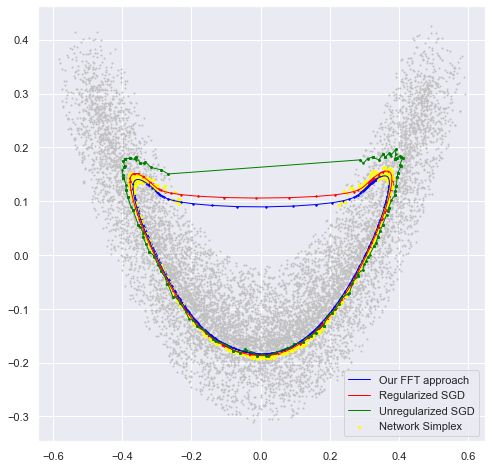

In [21]:
# Visualisation d'un quantile
plt.figure(figsize=(10,10))
plt.scatter(Y.T[0],Y.T[1],color="silver",s=1)

k = int(p1/2-1)
col1 = "blue"
plt.plot(hat_T1[k,:].reshape(p2,1),hat_T2[k,:].reshape(p2,1),color=col1,linewidth=1,label="Our FFT approach")
plt.scatter(hat_T1[k,:].reshape(p2,1),hat_T2[k,:].reshape(p2,1),color=col1,s=2)

col2 = "red"
plt.plot(hatT_RM1[k,:].reshape(p2,1),hatT_RM2[k,:].reshape(p2,1),color=col2,linewidth=1,label="Regularized SGD")
plt.scatter(hatT_RM1[k,:].reshape(p2,1),hatT_RM2[k,:].reshape(p2,1),color=col2,s=2)

plt.scatter(Contour05.T[0],Contour05.T[1],color="yellow",s=5,label="Network Simplex")

col3 = "green"
plt.plot(hatT_unreg1[k,:].reshape(p2,1),hatT_unreg2[k,:].reshape(p2,1),color=col3,linewidth=1,label="Unregularized SGD")
plt.scatter(hatT_unreg1[k,:].reshape(p2,1),hatT_unreg2[k,:].reshape(p2,1),color=col3,s=2)

plt.legend()

plt.savefig('Figures/fig2_discrete_contour50_unreg_p1_'+str(int(p1))+'_p2_'+str(int(p2))+'_epsilon_'+str(eps)+'_J_'+str(int(J))+'_n_iter_'+str(int(n_iter))+'.eps',bbox_inches='tight')
# plt.axis([-0.75,0.75,-0.5,0.5])

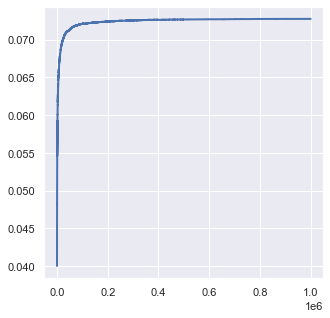

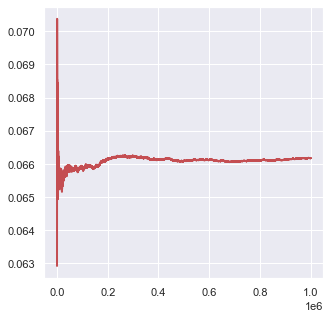

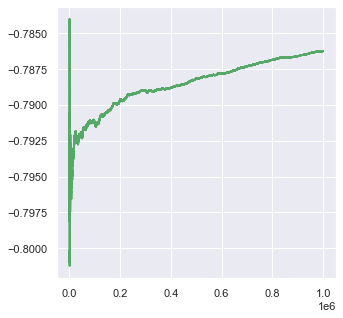

In [35]:
plt.figure(figsize=(5,5))
n_start = 200
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)
plt.savefig('Figures/fig2_discrete_hat_W_p1_'+str(int(p1))+'_p2_'+str(int(p2))+'_epsilon_'+str(eps)+'_J_'+str(int(J))+'_n_iter_'+str(int(n_iter))+'.eps',bbox_inches='tight')


plt.figure(figsize=(5,5))
plt.plot(np.arange(n_start,n_iter),hat_W_RM[n_start:],'r',linewidth=2)
plt.savefig('Figures/fig2_discrete_hat_W_RM_p1_'+str(int(p1))+'_p2_'+str(int(p2))+'_epsilon_'+str(eps)+'_J_'+str(int(J))+'_n_iter_'+str(int(n_iter))+'.eps',bbox_inches='tight')


plt.figure(figsize=(5,5))
plt.plot(np.arange(n_start,n_iter_unreg),hat_W_unreg[n_start:],'g',linewidth=2)
plt.savefig('Figures/fig2_discrete_hat_W_unreg_p1_'+str(int(p1))+'_p2_'+str(int(p2))+'_epsilon_'+str(eps)+'_J_'+str(int(J))+'_n_iter_'+str(int(n_iter))+'.eps',bbox_inches='tight')